In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

from keras.models import Model
from keras.layers import Lambda, Input, Dense
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

Using TensorFlow backend.


In [2]:
class LaserScans:
    def __init__(self, datafile, clip_scans_at=8, scan_bound_percentage=0.15, verbose=False):
        self.verbose = verbose
        self.data = np.loadtxt(datafile).astype('float32')
        self.clip_scans_at = clip_scans_at
        self.scan_bound_percentage = scan_bound_percentage
        self.timesteps = self.data[:, :1]
        self.cmd_vel = self.data[:, 1:7]
        self.scans = self.data[:, 7:]
        
        if self.verbose: 
            print("timesteps --", self.timesteps.shape)
            print("cmd_vel --", self.cmd_vel.shape)
            print("scans --", self.scans.shape, "ranges [", np.max(self.scans), "-", np.min(self.scans), "]")
            
        np.clip(self.scans, a_min=0, a_max=clip_scans_at, out=self.scans)
        
        # bounds are due to the embodiment of the particular robot used, this should not exist!!!
        min_bound = int(self.scan_bound_percentage*self.scans.shape[1])
        max_bound = int(self.scans.shape[1] - self.scan_bound_percentage*self.scans.shape[1])
        if self.verbose: print("scans bounds (min, max)=", min_bound, max_bound)
        
        self.scans = self.scans[:, min_bound:max_bound] / self.clip_scans_at    # normalization makes the vae work
    
    def originalScansDim(self):
        return self.scans.shape[1]
    
    def timesteps(self):
        return self.timesteps
    
    def cmdVel(self):
        return self.cmd_vel
    
    def getScans(self, split_at=0):
        if split_at == 0: return self.scans
        
        x_train = self.scans[:int(self.scans.shape[0]*split_at),:]
        x_test = self.scans[int(self.scans.shape[0]*split_at):,:]
        
        if self.verbose:
            print("scans train:", x_train.shape)
            print("scans test:", x_test.shape)
            
        return x_train, x_test
    
    def getScanSegments(self, scan, threshold):
        segments = []
        iseg = 0
        useg = bool(scan[0] > threshold)
        for d in range(scan.shape[0]):
            if useg and scan[d] < threshold:
                segments.append([iseg, d, useg])
                iseg = d
                useg = False
            if not useg and scan[d] > threshold:
                segments.append([iseg, d, useg])
                iseg = d
                useg = True
            if d == scan.shape[0] - 1: segments.append([iseg, d, useg])
        return segments
    
    def plotScanSegments(self, scan, y=None):
        lstep = (3/2)*np.pi/720
        theta = np.arange(self.scan_bound_percentage*(3/2)*np.pi, 
                          (1 - self.scan_bound_percentage)*(3/2)*np.pi, lstep) - self.scan_bound_percentage*(3/2)*np.pi
        theta = theta[::-1]

        x_axis = np.arange(scan.shape[0])
        segments = self.getScanSegments(scan, 0.99)
        if self.verbose: print("Segments -- ", np.array(segments).shape, "--", segments)

        plt.figure()
        y_axis = scan
        if y != None: y_axis = y

        plt.plot(x_axis, scan, color='lightgray')
        for s in segments:
            if s[2]: 
                col = '#ff7f0e'
                plt.plot(x_axis[s[0]:s[1]], y_axis[s[0]:s[1]], 'o', markersize=0.5, color=col)
            else:
                col = '#1f77b4'
                plt.plot(x_axis[s[0]:s[1]], scan[s[0]:s[1]], 'o', markersize=0.5, color=col)

        plt.figure()
        ax = plt.subplot(111, projection='polar')
        ax.plot(theta, scan, color='lightgray')
        for s in segments:
            if s[2]: 
                col = '#ff7f0e'
                ax.plot(theta[s[0]:s[1]], y_axis[s[0]:s[1]], 'o', markersize=0.5, color=col)
            else:
                col = '#1f77b4'
                ax.plot(theta[s[0]:s[1]], scan[s[0]:s[1]], 'o', markersize=0.5, color=col)

In [19]:
class VAE:
    def __init__(self, batch_size=128, latent_dim=10, intermediate_dim=128, verbose=False):
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.intermediate_dim = intermediate_dim
        self.verbose = verbose

    def sampling(self, args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        # by default, random_normal has mean=0 and std=1.0
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
    def buildModel(self, original_dim):
        input_shape = (original_dim, )

        # VAE model = encoder + decoder
        # build encoder model
        inputs = Input(shape=input_shape, name='encoder_input')
        x = Dense(self.intermediate_dim, activation='relu')(inputs)
        z_mean = Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(x)

        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(self.sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])

        # instantiate encoder model
        self.encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
        if self.verbose: encoder.summary()

        # build decoder model
        latent_inputs = Input(shape=(self.latent_dim,), name='z_sampling')
        x = Dense(self.intermediate_dim, activation='relu')(latent_inputs)
        outputs = Dense(original_dim, activation='sigmoid')(x)

        # instantiate decoder model
        self.decoder = Model(latent_inputs, outputs, name='decoder')
        if self.verbose: decoder.summary()

        # instantiate VAE model
        outputs = self.decoder(self.encoder(inputs)[2])
        self.vae = Model(inputs, outputs, name='vae_mlp')
        
        reconstruction_loss = binary_crossentropy(inputs, outputs)
        reconstruction_loss *= original_dim
        
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        
        self.vae.add_loss(vae_loss)
        self.vae.compile(optimizer='adam')
        if self.verbose: self.vae.summary()
    
    def fitModel(self, x, x_test=None, epochs=10, verbose=None):
        if x_test is None:
            self.vae.fit(x,
                         epochs=epochs,
                         batch_size=self.batch_size,
                         verbose=verbose)
        else:
            self.vae.fit(x,
                         epochs=epochs,
                         batch_size=self.batch_size,
                         verbose=verbose,
                         validation_data=(x_test, None))
    
    def predictEncoder(self, x, batch_size=None):
        if len(x.shape) == 1: x = np.array([x])
        z_mean, _, _ = self.encoder.predict(x, batch_size=batch_size)
        return z_mean
    
    def predictDecoder(self, z_mean):
        x_decoded = self.decoder.predict(z_mean)
        return x_decoded

In [4]:
if __name__ == "__main__":
    # DIAG_first_floor.txt 
    # diag_labrococo.txt
    # diag_underground.txt
    ls = LaserScans("../../dataset/diag_underground.txt", verbose=True)

timesteps -- (13545, 1)
cmd_vel -- (13545, 6)
scans -- (13545, 721) ranges [ 30.0 - 0.0 ]
scans bounds (min, max)= 108 612


In [20]:
    vae = VAE()
    vae.buildModel(ls.originalScansDim())
    vae.fitModel(ls.getScans(), epochs=10, verbose=0)
    
    x, x_test = ls.getScans(0.9)
    # vae.fitModel(x, x_test=x_test)

scans train: (12190, 504)
scans test: (1355, 504)


Segments --  (5, 3) -- [[0, 159, False], [159, 228, True], [228, 243, False], [243, 246, True], [246, 503, False]]


/home/sapienzbot/.local/lib/python3.5/site-packages/ipykernel_launcher.py:74: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


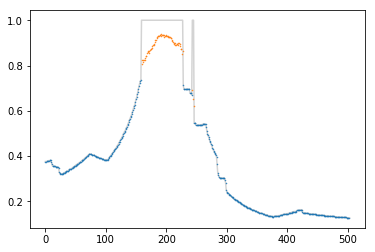

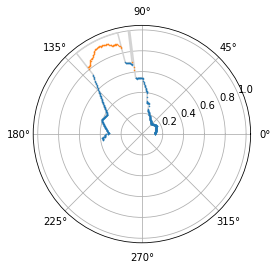

In [21]:
    scan = x[1000]
    dscan = vae.predictDecoder(vae.predictEncoder(scan))
    ls.plotScanSegments(scan, dscan[0])